# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Finding a suitable place to run a restaurant in the city of Visakhapatnam, India

## Table of Contents

* [Introduction: Business problem](#introduction)
* [Data](#data_collection)
* [Data Processing](#data_processing)
* [Methodolgy](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction : Business problem <a name="introduction"></a>

**Visakhapatnam** is one of the beautiful cities of India. It has population of around 20 Lakhs and population <br>
density of 3000  per square kilometre. I have been residing in this city for 2 decades. <br>
The city is one the prominent destiny of tourism. This city has a name as **"City of destiny"** with an area of <br>
approximately 11160 square kilometers with 4 administrative divisions. Because of its atmosphere many tourists <br>
keep coming to this place. <br>
I have decided to do a small project to give options to make a choice of where a business enclave like a restaurant <br>
or a hotel or anything of that sort can established. <br>
This work can in a way help new entrepreneurs to start their business in the city of destiny

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes  
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py36h5fab9bb_0 --> 2020.12.5-py36h5fab9bb_1



geopy-2.1.0          | 64 KB     

# Data <a name="data_collection"></a>

### Data Collection from APIs and preprocessing 

To begin with, A look at **Visakhapatnam on the Map** is tried using the `folium` library.

data is collected from **two different APIs**.
* **Foursquare API:** to fetch venues in Visakhapatnam with a range of 15 Kilometers from center.
* **Zomato API:** The information of user ratings, price for two people, price range are used from the Zomato API.

Based on definition of our problem, factors that will influence our decission are:
* Clusters of existing restaurants based on rating
* Clusters of existing restaurants based
on average price
* Places of restaurents with poor rating and high prices

### Visakhapatnam(Vizag) city

There are many venues (especially restaurants, hotels and cafes) which can be explored.

`geopy` library is used to extract the latitude and longitude values of Visakhapatnam but direct values of latitude and longitude values of Visakhapatnam can also be used.

In [2]:
address = 'visakhapatnam'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

17.7231276 83.3012842


`folium` library can be used to create a **complete map on Vizag with zoom**. A marker on the coordinates would give us a relatively good look at the center point. 

In [3]:
VZG_LATITUDE = latitude
VZG_LONGITUDE = longitude

In [4]:
vizag_map = folium.Map(location = [VZG_LATITUDE, VZG_LONGITUDE], zoom_start = 13)
folium.Marker([VZG_LATITUDE, VZG_LONGITUDE]).add_to(vizag_map)
#vizag_map.save("maps/vizag Map.html")
vizag_map

### Foursquare API

All venues in **Visakhapatnam** over a range of 15 Kilometers are fetched using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. This API can be used to find all the venues we need.

In [6]:
FOURSQUARE_CLIENT_ID = 'id'
FOURSQUARE_CLIENT_SECRET = 'client'
RADIUS = 15000 # 4 Km
NO_OF_VENUES = 100
VERSION = 'dt' # Current date

The API is used over and over till all venues from the API within the given distance are fetched. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* The radius is set as 15 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In order to avoid multiple use of online API json file is generated.

In [9]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        VZ_LATITUDE, 
                                                                        VZ_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 66 venues fetched within a total radius of 15.0 Km

Total 66 venues fetched


A json file is created to retrive data. Now open the json file and form vizag_venues dataframe.

We define the `get_category_type` method to get the correct category for each venue.

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
# test above with json file
with open('vizag_data.json') as json_data:
    vizag_raw = json.load(json_data)

venues = vizag_raw['response']['groups'][0]['items']
    
vizag_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
vizag_venues = vizag_venues.loc[:, filtered_columns]

# filter the category for each row
vizag_venues['venue.categories'] = vizag_venues.apply(get_category_type, axis=1)

# clean columns
vizag_venues.columns = [col.split(".")[-1] for col in vizag_venues.columns]

vizag_venues.head()



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


,name,categories,lat,lng
0,Ramakrishna Mission Beach,Beach,17.715271,83.324016
1,Cream & Fudge,Ice Cream Shop,17.719339,83.311927
2,Novotel Varun Beach,Restaurant,17.710712,83.316263
3,Novotel Visakhapatnam Varun Beach,Hotel,17.710829,83.316218
4,Food Ex,Fast Food Restaurant,17.722155,83.318422


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

The `name`, `lat`, and `lng` values of various venues fetched from Foursquare API are used to the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

The Zomato data set is built as vizag_zomato.csv file from  https://developers.zomato.com

This data data is saved as a CSV file in order to avoid multiple fetches every time we run the notebook

In [41]:
zomato_venues = pd.read_csv('vizag_zomato.csv')
zomato_venues.head()

,Unnamed: 0,venue,latitude,longitude,price_for_two,price_range,rating,address
0,0,Coffee Wave,17.715136,83.324426,500,2,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga..."
1,1,Mumbai Kulfi,17.718523,83.308448,150,1,4.0,"10-53-280, LIG-6/3, Nehrunagar Quarters, Ram N..."
2,2,Infinity - Hotel Novotel,17.710937,83.316146,2000,4,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag"
3,3,Infinity - Hotel Novotel,17.710937,83.316146,2000,4,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag"
4,4,Food Ex,17.721970,83.318490,700,2,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS..."


In [9]:
print('shape of foursqare and zomato venues\n')
print(vizag_venues.shape)
print(zomato_venues.shape)

shape of foursqare and zomato venues

(70, 4)
(69, 8)


# Data Processing <a name="data_processing"></a>

The data from multiple resources might not always align and the sizes may not be alike as shown above. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [11]:
vizag_map = folium.Map(location = [VZG_LATITUDE, VZG_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(vizag_venues['name'], vizag_venues['lat'], vizag_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(vizag_map)  

vizag_map.save("Venues by vizag.html")
vizag_map

From the map, we can infer that there are clusters of venues around **center** and **Beach road**. We can also plot the category count and see the major type of venues that exist.

A plot of the Zomato data on the map also helps
.

In [12]:
vizag_map = folium.Map(location = [VZG_LATITUDE, VZG_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(vizag_map)  

vizag_map.save("Venues by Zomato.html")
vizag_map

We can see that there are many venues identified by both Foursquare and Zomato.There are others where the data does not match just like the red dots in the bottom right on the second map.

To combine the two datasets, check that the latitude and longitude values of each corresponding venue match. Round both the latitude and longitude values upto 4 decimal places. Then, calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [13]:
vizag_venues['lat'] = vizag_venues['lat'].apply(lambda lat: round(float(lat), 4))
vizag_venues['lng'] = vizag_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [14]:
dataset = pd.concat([vizag_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [15]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues.head()
print('The shape of selected venues is')
selected_venues.shape

The shape of selected venues is


(34, 14)

There is a drop in number of venues to 34 and there is a venue with same name and hence it needs to be removed

In [16]:
selected_venues_final = selected_venues.drop([2]).reset_index(drop = True)

In [17]:
selected_venues_final.shape

(33, 14)

Selected venues now are 33

It s needed to get the average price per person by dividing the column `price_for_two` by 2 and remove the column `price_for_two`<br> from the dataset along with other unnecessary columns.

In [17]:
selected_venues_final['average_price'] = selected_venues_final['price_for_two']/2
selected_venues_final = selected_venues_final.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [18]:
selected_venues_final.shape

(33, 9)

Let's take a look at the final dataset that is left with us.

In [19]:
selected_venues_final.head()

,categories,Unnamed: 0,venue,latitude,longitude,price_range,rating,address,average_price
0,Beach,0.0,Coffee Wave,17.7151,83.3244,2.0,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga...",250.0
1,Restaurant,2.0,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0
2,Fast Food Restaurant,4.0,Food Ex,17.7220,83.3185,2.0,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS...",350.0
3,Indie Movie Theater,6.0,Hotel Attarillu,17.7120,83.3025,1.0,3.8,"Beside KLM Shopping Mall Jagadamba Junction, V...",125.0
4,Indian Restaurant,7.0,Sri Sairam Parlour,17.7263,83.3034,1.0,4.4,"Diamond Park, Railway New Colony Road, Dwaraka...",150.0


In [20]:
selected_venues_final = selected_venues_final.drop(columns=['Unnamed: 0'])

In [21]:
selected_venues_final.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Beach,Coffee Wave,17.7151,83.3244,2.0,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga...",250.0
1,Restaurant,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0
2,Fast Food Restaurant,Food Ex,17.7220,83.3185,2.0,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS...",350.0
3,Indie Movie Theater,Hotel Attarillu,17.7120,83.3025,1.0,3.8,"Beside KLM Shopping Mall Jagadamba Junction, V...",125.0
4,Indian Restaurant,Sri Sairam Parlour,17.7263,83.3034,1.0,4.4,"Diamond Park, Railway New Colony Road, Dwaraka...",150.0


drop the venues which have `0.0` rating as it means it's not been rated yet.

In [22]:
selected_venues_final = selected_venues_final[selected_venues_final['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues_final.shape[0]))
selected_venues_final

Total venues available: 29


,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Beach,Coffee Wave,17.7151,83.3244,2.0,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga...",250.0
1,Restaurant,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0
2,Fast Food Restaurant,Food Ex,17.7220,83.3185,2.0,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS...",350.0
3,Indie Movie Theater,Hotel Attarillu,17.7120,83.3025,1.0,3.8,"Beside KLM Shopping Mall Jagadamba Junction, V...",125.0
4,Indian Restaurant,Sri Sairam Parlour,17.7263,83.3034,1.0,4.4,"Diamond Park, Railway New Colony Road, Dwaraka...",150.0
5,Snack Place,Sweet India,17.7251,83.3166,1.0,4.3,"Dno: 10-1-44, CBM Compound, Visakhapatnam, Sri...",75.0
6,Multiplex,Baskin Robbins,17.7110,83.3158,1.0,3.4,"Sarvani traders(baskin robbins), Ground Floor,...",100.0
7,Café,Pastry Coffee N Conversation,17.7240,83.3180,2.0,3.3,"21, Siripuram Junction, Dutt Island, Siripuram...",200.0
8,Hotel,Mekong - Hotel GreenPark,17.7157,83.3063,3.0,4.4,"Hotel GreenPark, Waltair Main Road, Waltair Up...",650.0
9,Food Court,Laddu Gopal Sweets,17.7415,83.3332,2.0,3.9,"D. 83-23/3, Sector 5, MVP Colony, Vizag",250.0


# Methodology <a name="methodology"></a>

This project aims at track the venues in Visakhapatnam based on their rating and average costs. This would enable any investor to identify the places where he/she wants to establish the restaurent.The following operations are performed to choose the place.

* **Identify the right business** in the city based on number of establishments presently existing. <br>
<br>
* **Identify places where many venues are located** so that any investor can choose the place amongst many venue options. <br> 
<br>
* Explore **areas that are high rated and those that are low rated** <br>
<br>
* Explore **high and low priced venues**. <br>
<br>
* **Cluster the venues** based on the available information of each venue. This will allow us to clearly identify which place can be recommended and with what characteristics.<br>
<br>


### Right business 

The complete dataset is now in its final form. 


We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

<BarContainer object of 19 artists>

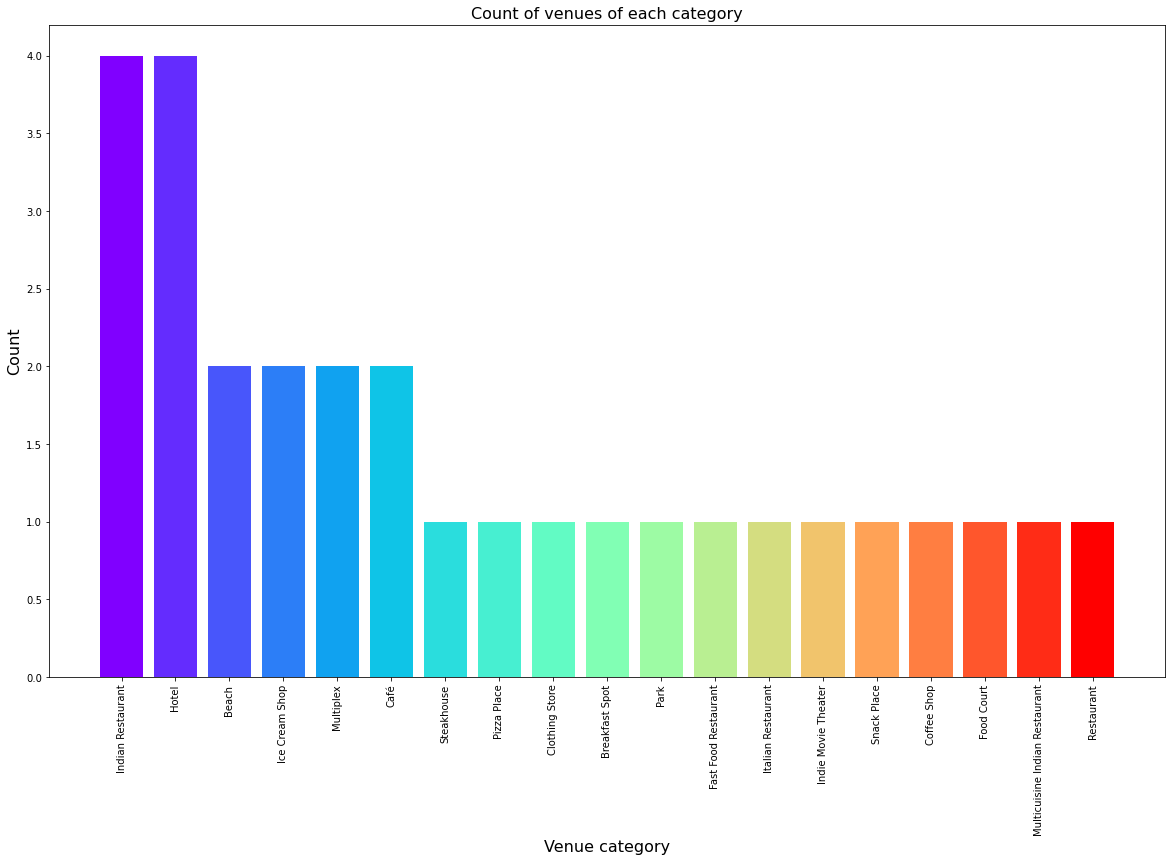

In [24]:
venue_distribution = selected_venues_final['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

Majority venues are  **Hotel**, **Indian Restaurant** and **Cafe**. Hence the best business can be restaurent

### Rating

**Inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. Also **analyse the venues based on their price per person as well as the price range**. 

Rating of a venue is an important factor on which an enteprenuar can accertain quality of venue. <br> If ther are more venues with low quality then the place can be viable place for him. <br> in order to do this, first find the average rating for all the venues in the city and plot the venues on the map and color code them.

Identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

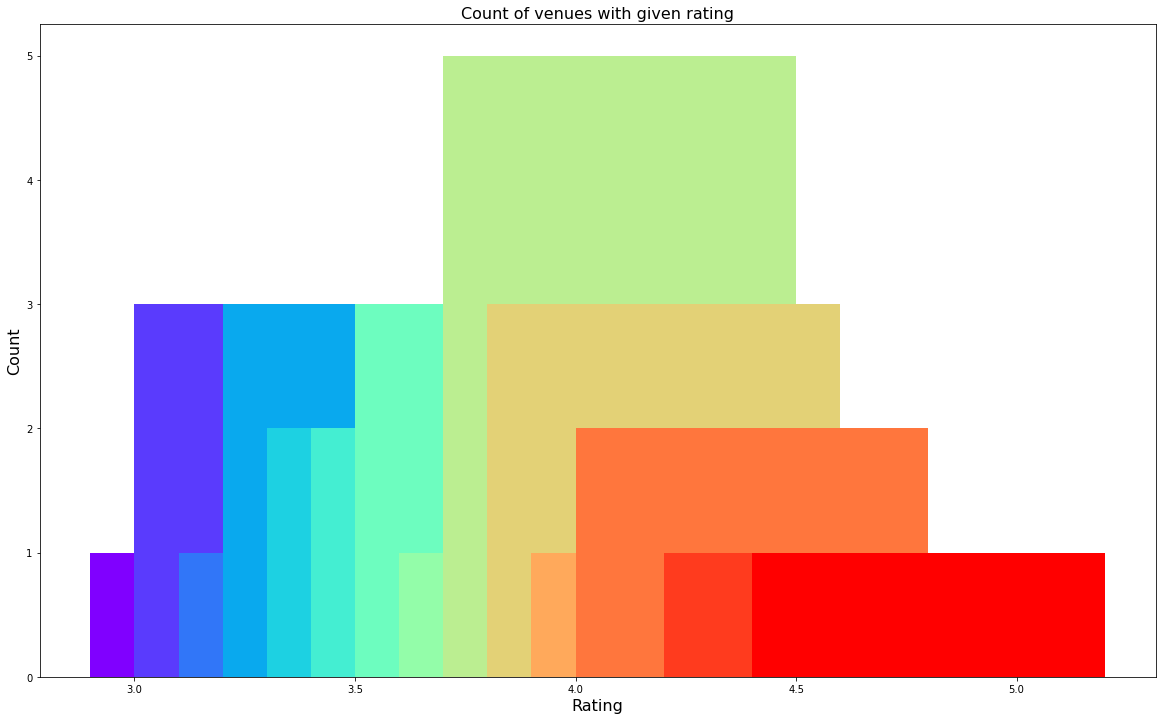

In [25]:
rating = selected_venues_final['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **all** have their **rating in range 3 to 5**.

Create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [26]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues_final['rating_bin'] = pd.cut(selected_venues_final['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [27]:
selected_venues_final.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,Beach,Coffee Wave,17.7151,83.3244,2.0,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga...",250.0,Good
1,Restaurant,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0,Very good
2,Fast Food Restaurant,Food Ex,17.7220,83.3185,2.0,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS...",350.0,Very good
3,Indie Movie Theater,Hotel Attarillu,17.7120,83.3025,1.0,3.8,"Beside KLM Shopping Mall Jagadamba Junction, V...",125.0,Good
4,Indian Restaurant,Sri Sairam Parlour,17.7263,83.3034,1.0,4.4,"Diamond Park, Railway New Colony Road, Dwaraka...",150.0,Very good


Now, plot the venues on the map.

In [28]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

vizag_map = folium.Map(location = [VZG_LATITUDE, VZG_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues_final['venue'], 
                                                          selected_venues_final['address'], 
                                                          selected_venues_final['latitude'], 
                                                          selected_venues_final['longitude'], 
                                                          selected_venues_final['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(vizag_map)  

vizag_map.save("Venues Ratings.html")
vizag_map

The map has the location of all the venues. It appears that many venues are located near about **waltair uplands** and **central vizag** with rating above 3.

### Price

Take a look the venues based on the price values. There are two price features for all venues, one is `average_price` which defines the average cost for one person and the other is `price_range` which determines the price range as defined by Zomato.

Explore the `average_price` using a scatter plot between the price and the count of venues with that average price.Size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

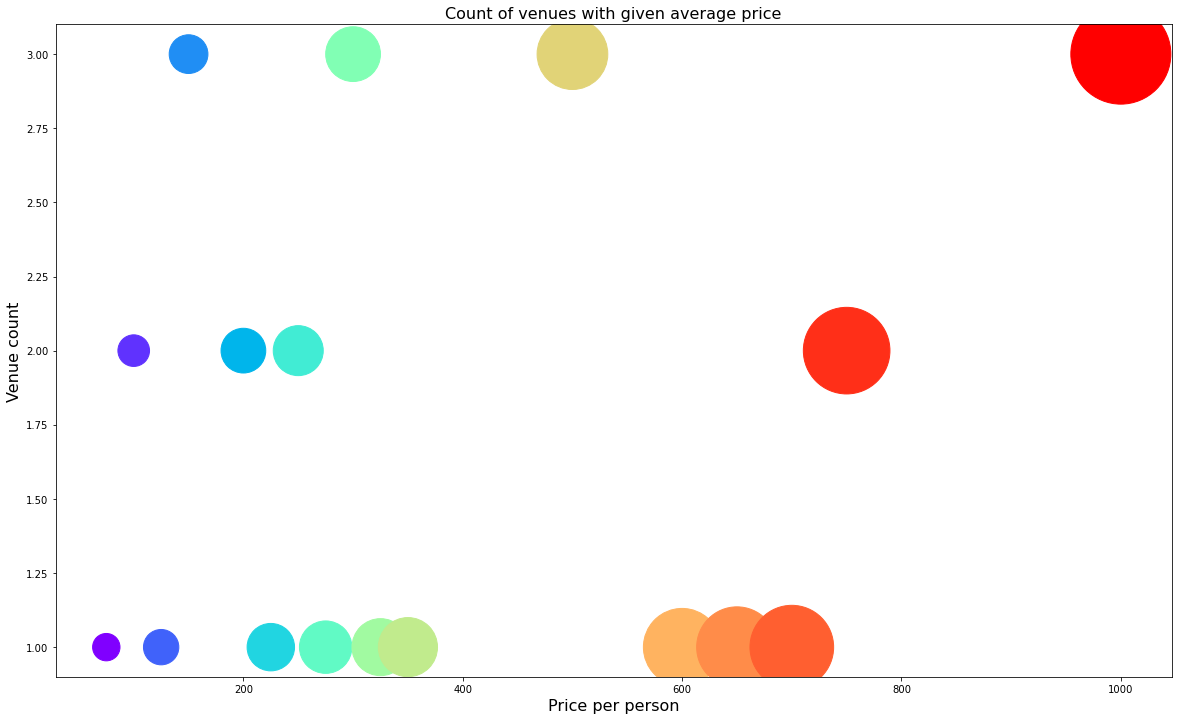

In [29]:
average_prices = selected_venues_final['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above it is identified that a large number of venues have an average price between Rs 200 and Rs 800.

In [31]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

vizag_map = folium.Map(location = [VZG_LATITUDE, VZG_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues_final['venue'], 
                                                           selected_venues_final['address'], 
                                                           selected_venues_final['latitude'], 
                                                           selected_venues_final['longitude'], 
                                                           selected_venues_final['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(vizag_map)  

vizag_map.save("Venues Prices.html")
vizag_map

1. The venues around Siripuram are of lower price.
2. The venues in beach road have steep prices.
3. other parts have a mix of both high priced and low priced venues.

### Clustering

Now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. Cluster the venues into two separate groups.

In [32]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues_final.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues_final.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues_final.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Beach,Coffee Wave,17.7151,83.3244,2.0,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga...",250.0,Good
1,0,Restaurant,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0,Very good
2,1,Fast Food Restaurant,Food Ex,17.7220,83.3185,2.0,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS...",350.0,Very good
3,1,Indie Movie Theater,Hotel Attarillu,17.7120,83.3025,1.0,3.8,"Beside KLM Shopping Mall Jagadamba Junction, V...",125.0,Good
4,1,Indian Restaurant,Sri Sairam Parlour,17.7263,83.3034,1.0,4.4,"Diamond Park, Railway New Colony Road, Dwaraka...",150.0,Very good


All the venues have rating either GOOD or VERY GOOD. 

In [33]:
vizag_map = folium.Map(location = [VZG_LATITUDE, VZG_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues_final['venue'], 
                                                        selected_venues_final['address'], 
                                                        selected_venues_final['cluster_labels'], 
                                                        selected_venues_final['latitude'], 
                                                        selected_venues_final['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(vizag_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(vizag_map)

vizag_map.save("Venues Clusters on Rating.html")
vizag_map

From the map, we see the two clusters:
1. The first cluster is spread across the whole city and includes the majority venues.
2. The second cluster is confined to limited places and has very limited venues.

Check the venues of the two clusters.

In [34]:
result = selected_venues_final[selected_venues_final['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Restaurant,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0,Very good
1,0,Hotel,Mekong - Hotel GreenPark,17.7157,83.3063,3.0,4.4,"Hotel GreenPark, Waltair Main Road, Waltair Up...",650.0,Very good
2,0,Steakhouse,Infinity - Hotel Novotel,17.7109,83.3161,4.0,4.1,"Hotel Novotel, Beach Road, Maharani Peta, Vizag",1000.0,Very good
3,0,Hotel,Aqua - The Park,17.7215,83.3366,4.0,3.7,"The Park, Beach Road, Pedda Waltair, Lawsons B...",750.0,Good
4,0,Beach,Rayalaseema Ruchulu,17.7187,83.3312,3.0,3.6,"Ambica Sea Green, Beach Road, Opposite Submari...",500.0,Good
5,0,Italian Restaurant,Flying Spaghetti Monster,17.7212,83.3149,3.0,4.8,"10-50-12/F2, Sai Dakshata Complex, Beside Leno...",700.0,Very good
6,0,Multicuisine Indian Restaurant,Barbeque Nation,17.7174,83.3185,3.0,4.1,"Door 7-8-10, Pandurangapuram, Siripuram, Vizag",600.0,Very good
7,0,Clothing Store,Sri Sivarama Sweets,17.7092,83.3009,3.0,4.1,"South Jail Road, Suryabagh, Opposite Vizag Cen...",500.0,Very good
8,0,Hotel,Ming Garden - The Gateway Hotel,17.7112,83.3169,4.0,4.1,"The Gateway Hotel, Beach Road, Maharani Peta, ...",1000.0,Very good
9,0,Hotel,Cascades,17.7133,83.2975,3.0,3.6,"Dolphin Hotel, 75 Feet Road, Daba Gardens, Bes...",500.0,Good


In [35]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 3.45 and rating spread around 4.01


It is concluded that <br> **cluster 0** <br> **price range: 3.45** <br> **Rating: 4.01**   

In [36]:
result = selected_venues_final[selected_venues_final['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Beach,Coffee Wave,17.7151,83.3244,2.0,3.8,"RK Beach Road, Next to Bay Fashion, Panduranga...",250.0,Good
1,1,Fast Food Restaurant,Food Ex,17.7220,83.3185,2.0,4.2,"Block A, VUDA Complex, Udyog Bhavan, Behind HS...",350.0,Very good
2,1,Indie Movie Theater,Hotel Attarillu,17.7120,83.3025,1.0,3.8,"Beside KLM Shopping Mall Jagadamba Junction, V...",125.0,Good
3,1,Indian Restaurant,Sri Sairam Parlour,17.7263,83.3034,1.0,4.4,"Diamond Park, Railway New Colony Road, Dwaraka...",150.0,Very good
4,1,Snack Place,Sweet India,17.7251,83.3166,1.0,4.3,"Dno: 10-1-44, CBM Compound, Visakhapatnam, Sri...",75.0,Very good
5,1,Multiplex,Baskin Robbins,17.7110,83.3158,1.0,3.4,"Sarvani traders(baskin robbins), Ground Floor,...",100.0,Good
6,1,Café,Pastry Coffee N Conversation,17.7240,83.3180,2.0,3.3,"21, Siripuram Junction, Dutt Island, Siripuram...",200.0,Good
7,1,Food Court,Laddu Gopal Sweets,17.7415,83.3332,2.0,3.9,"D. 83-23/3, Sector 5, MVP Colony, Vizag",250.0,Good
8,1,Café,Cafe Coffee Day,17.7249,83.3144,2.0,3.9,"1st Floor, The Landmark Building, CBM Compound...",325.0,Good
9,1,Park,Salt And Pepper,17.7477,83.3494,1.0,3.4,"Down Of Kailasha Giri Hill, Teneti Park, Visha...",150.0,Good


In [37]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.61 and rating spread around 3.89


It is concluded that <br> **cluster 1** <br> **price range: 1.61** <br> **Rating: 3.89**  

# Results and Discussion <a name="results"></a>

Based on the given analysis above, some conclusions can be drawn which will help any one who wish to establish a restaurant in the city of Visakhapatnam, India.

A list of 70 different venues were found after collecting data from the **Foursquare** and **Zomato** APIs. Since the venues from the two APIs were not identical, their latitude and longitude values as well as names are to be derived to combine them and remove all the outliers. This resulted in a total venue count of 34.

It is identified that the majority of venues are **Hotels**, **Indian Restaurants** and **Cafes**  from the final list of venues. 

Ratings were grouped to 4 groups as 1-2, 2-3,3-4, 4-5. Thorough observation gives the information that the **majority venues have ratings between 4 to 5**. This means that most restaurants provide good or very good food in the the city, thus indicating the high ratings. When these venues plotted on the map, it is discovered that there are clusters of venues scattered around the city. These clusters also have very **high ratings (more than 3)**. Observations inform us that the area aound central visakha and Siripuram have slightly lower ratings. Beach road has higher ratings. 

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 200 to Rs 800 for one person. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. On plotting the venues based on their price range on the map, we discovered that venues located near **Siripuram** and **central vizag** are relatively priced lower than venues in **beach**.

1. If the enterprenuar wish to establish a high priced high rated restaurent he better opt for beach road.
2. If enterprenuar wish to establish a mid priced and high rated restaurent he better choose Siripuram or central Vizag.

It can be concluded that **the best place** to choose for establishing a quality resatuarent would be the Siripuram area or central Vizag as there are less number of good rated venues are existing in those areas.


## Conclusion <a name="conclusion"></a>

This work explores the places that an enterprenuar would wish to start a business entity inthe city of Visakhapatnam. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can establish a business entity Beach road, central vizag and Siripuram area. Based on the visitor's venue rating and price requirements, he can choose amongst the three places.